# Sparkify Project Workspace
This workspace contains all the steps in the analysis and modelling of the data.

## Overview
Sparkify is a music streaming service which has paid and free customers. They have tasked me to buid a model that predicts which users are likely to churn prior to the event happening. Sparkify would send the customers that are considered at risk of churning offers or other insentives to stay with the paid service. 

The data provided by Sparkify includes customer demographic and service interaction data, all timestamped. The original dataset is 12GB, but due to resource restrictions I worked with the medium 242MB subset of the data using PySpark.

After the data is cleaned, pre-processed and explored nine features are engineered from the dataset variables. F1 score is used as the measure of performance of the models taht were compared, due to the imbalanced nature of the labels (significantly more users have not churned). Baseline model performance was noted and subsequent models' F1 scores were compared against that figure. 

Gradient Boosted Tree Classifier came out to have the best predictive power with F1 score being 86% and was recommended for use in this scenario. The most important features were identified, top three of which are: average number of songs played, number of 'thumbs down' given and total number of sessions, which were anticipated.


## Table of Contents
- Data pre-processing
    - Missing Data
    - Defining Churn
    - Explore Data
- Feature Engeneering
- Modelling
    - Vectorise the features
    - Normalise the features
    - Split the dataset
    - Compute baseline F1 score
    - Build and Train models
    - Hyperparameter tuning
- Conclusion

In [1]:
# import pyspark related libraries
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.functions import *
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# import pandas, matplotlib, and seaborn for visualization and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import datetime for parsing datetime object
import datetime

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191009173434-0001
KERNEL_ID = 6f2a5124-97db-4480-bfed-56496eea0ca5


## Data pre-processing
In this workspace, the subset file is `medium_sparkify_event_data.json` from the IBM Watson Studio Cloud Object Storage. Load and clean the dataset, checking for invalid or missing data

In [2]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-e7c76399-a89e-4974-9557-ba5c60d5daa1',
    'iam_service_endpoint': 'https://iam.eu-gb.bluemix.net/oidc/token',
    'api_key': 'KE2C-XN165hErEFnJNrUpzaVMTCI67o6SOqm2jwV2gZY'
}

configuration_name = 'os_6244885cda944e7ebb1285a93c7c42bd_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [3]:
df_spark = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-10odilmza0szjs'))
df_spark.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [4]:
df_spark.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Missing data

In [5]:
print("There are {} rows before data pre-processing is done".format(df_spark.count()))

There are 543705 rows before data pre-processing is done


In [6]:
# Dropping NAs
df_spark = df_spark.dropna(subset = ["userId", "sessionId"])

In [7]:
df_spark.select('userId').dropDuplicates().sort('userId').show(3)

+------+
|userId|
+------+
|      |
|    10|
|   100|
+------+
only showing top 3 rows



As can be seen from above, there are empty values for the userID column which must be removed

In [8]:
df_spark = df_spark.filter(df_spark['userId'] != '')

In [9]:
print("There are {} rows before data pre-processing is done".format(df_spark.count()))

There are 528005 rows before data pre-processing is done


So, it can be seen that 15,700 recotds had an empty string for the userId value and hence been removed.

In [10]:
df_spark.select('sessionId').dropDuplicates().sort('sessionId').show(3)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
+---------+
only showing top 3 rows



It can also be seen that sessionId column has no missing values.

In [11]:
# For ease of visualisation, I will add a pandas dataframe
df_pd = df_spark.toPandas()
df_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1532063507000,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1538069638000,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1535953455000,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1535953455000,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1535931018000,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246


### Defining Churn
Now that the dataset has been cleaned, the churn column will be created which will be used as the target label for the model later on. The indicator for churn action will be 'Cancellation Confirmation' value for 'page' column. Downgrade action will also be investigated. 

In [12]:
df_pd.page.unique()

array(['NextSong', 'Logout', 'Home', 'Downgrade', 'Add to Playlist',
       'Roll Advert', 'Thumbs Up', 'Help', 'Thumbs Down', 'Add Friend',
       'Settings', 'Save Settings', 'Upgrade', 'About',
       'Submit Downgrade', 'Cancel', 'Cancellation Confirmation',
       'Submit Upgrade', 'Error'], dtype=object)

In [13]:
df_pd[df_pd['page'] == 'Cancellation Confirmation']

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
2454,None,Cancelled,Olivia,F,40,Carr,NaN,free,"Fort Wayne, IN",GET,Cancellation Confirmation,1536758439000,490,None,200,1538400616000,Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...,208
6550,None,Cancelled,Lillian,F,234,Cameron,NaN,paid,"Columbus, OH",GET,Cancellation Confirmation,1533472700000,471,None,200,1538482793000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,231
12226,None,Cancelled,Alex,M,109,Myers,NaN,paid,"Grand Rapids-Wyoming, MI",GET,Cancellation Confirmation,1529995579000,682,None,200,1538539871000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",236
15768,None,Cancelled,Rafael,M,66,Crawford,NaN,free,"Bowling Green, KY",GET,Cancellation Confirmation,1533887620000,628,None,200,1538592529000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",156
28348,None,Cancelled,Brad,M,227,Stewart,NaN,paid,"Roanoke, VA",GET,Cancellation Confirmation,1535619094000,395,None,200,1538770077000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",271
30108,None,Cancelled,Isaac,M,193,Miller,NaN,paid,"Seattle-Tacoma-Bellevue, WA",GET,Cancellation Confirmation,1538201832000,862,None,200,1538800531000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,200
34008,None,Cancelled,Ivan,M,9,Sanchez,NaN,free,"Bridgeport-Stamford-Norwalk, CT",GET,Cancellation Confirmation,1533575236000,1027,None,200,1538890895000,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,130
35018,None,Cancelled,Chloe,M,56,Myers,NaN,free,"Tampa-St. Petersburg-Clearwater, FL",GET,Cancellation Confirmation,1534370883000,480,None,200,1538959081000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like M...",123
36381,None,Cancelled,Alexi,F,7,Warren,NaN,paid,"Spokane-Spokane Valley, WA",GET,Cancellation Confirmation,1532482662000,1010,None,200,1538987586000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
38552,None,Cancelled,Payton,F,82,Campbell,NaN,paid,"Los Angeles-Long Beach-Anaheim, CA",GET,Cancellation Confirmation,1529027541000,1066,None,200,1539011456000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",39


In [14]:
print("There are {} rows with 'Cancellation Confirmation' value for page column".format(df_pd[df_pd['page'] == 'Cancellation Confirmation'].shape[0]))

There are 99 rows with 'Cancellation Confirmation' value for page column


I will first create a label for downgrade event and flag the users who have downgraded and then do the same for churn action and users who churned.

In [15]:
# create downgrade label
down_label = udf(lambda page: 1 if page == 'Submit Downgrade' else 0, IntegerType())
df_spark = df_spark.withColumn('downgrade_event', down_label('page'))

# create a label for users who have ever downgraded
windowval = Window.partitionBy('userId')
df_spark = df_spark.withColumn('downgrade', max('downgrade_event').over(windowval))

In [16]:
# create churn label
churn_label = udf(lambda page: 1 if page == 'Cancellation Confirmation' else 0, IntegerType())
df_spark = df_spark.withColumn('churn_event', churn_label('page'))

# create a label for users who have ever churned
df_spark = df_spark.withColumn('churn', max('churn_event').over(windowval))

In [17]:
# Let's have a look at the values in the new columns
df_spark.select(['userId','downgrade_event', 'downgrade', 'churn_event','churn']).dropDuplicates().show(10)

+------+---------------+---------+-----------+-----+
|userId|downgrade_event|downgrade|churn_event|churn|
+------+---------------+---------+-----------+-----+
|100010|              0|        0|          0|    1|
|100010|              0|        0|          1|    1|
|200002|              0|        0|          0|    1|
|200002|              0|        0|          1|    1|
|   296|              0|        0|          0|    1|
|   296|              0|        0|          1|    1|
|   125|              0|        0|          0|    0|
|   124|              0|        0|          0|    1|
|   124|              0|        0|          1|    1|
|    51|              0|        0|          0|    1|
+------+---------------+---------+-----------+-----+
only showing top 10 rows



Just to clarify the difference between the columns downgrade_event/downgrade and churn_event/churn:
The event column shows whether that row contains the downgrade or churn action (hence 'event') and the other columns shows whether that user has ever performed that action.

### Explore Data
Now that churn and downgrade has been defined, we can move onto performing some exploratory data analysis to observe the behavior for users who stayed vs users who churned. I am first going to prepare the time stampt column into an easier digestible form.

In [18]:
# Firstly, converting the time stamp to date and time format
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_spark = df_spark.withColumn('event_time', get_time('ts'))
df_spark = df_spark.withColumn('registration_time', get_time('registration'))

In [19]:
# Let's see how the new column looks
df_spark.select(["userId", "page", "event_time", "level", "song", 'registration_time']).where(df_spark.userId == "100").sort("event_time").show(5)

+------+-----------+-------------------+-----+------------------+-------------------+
|userId|       page|         event_time|level|              song|  registration_time|
+------+-----------+-------------------+-----+------------------+-------------------+
|   100|       Home|2018-10-01 00:04:01| free|              null|2018-09-26 17:17:35|
|   100|   NextSong|2018-10-01 00:04:19| free|  Teach Me Tonight|2018-09-26 17:17:35|
|   100|   NextSong|2018-10-01 00:07:40| free|You Only Live Once|2018-09-26 17:17:35|
|   100|Roll Advert|2018-10-01 00:07:40| free|              null|2018-09-26 17:17:35|
|   100|   NextSong|2018-10-01 00:10:47| free|      AsesÃÂ­name|2018-09-26 17:17:35|
+------+-----------+-------------------+-----+------------------+-------------------+
only showing top 5 rows



In [20]:
# Create an hour column
df_spark = df_spark.withColumn('hour', hour(df_spark.event_time).alias('hour'))

# Create a day column
df_spark = df_spark.withColumn('day', dayofmonth(df_spark.event_time).alias('day'))

# Create a month column
df_spark = df_spark.withColumn('month', month(df_spark.event_time).alias('month'))

In [21]:
# Let's make sure that the new columns looks as expected
df_spark.take(5)

[Row(artist='Darude', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Sandstorm', status=200, ts=1538991392000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', downgrade_event=0, downgrade=0, churn_event=0, churn=1, event_time='2018-10-08 09:36:32', registration_time='2018-09-27 02:45:40', hour=9, day=8, month=10),
 Row(artist='Justice', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=285.41342, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Phantom Part 1.5 (Album Version)', status=200, ts=1538991618000, userAgent='"Mozilla/5.0 (iPho

Now, we can go onto extracting and analysing downgrade and churn event and whether they are related to different variables that we have in the dataset. Let's remind ourselves, what the dataset looks like:

In [22]:
df_pd = df_spark.toPandas()
df_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,userId,downgrade_event,downgrade,churn_event,churn,event_time,registration_time,hour,day,month
0,Darude,Logged In,Darianna,F,0,Carpenter,226.08934,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,100010,0,0,0,1,2018-10-08 09:36:32,2018-09-27 02:45:40,9,8,10
1,Justice,Logged In,Darianna,F,1,Carpenter,285.41342,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,100010,0,0,0,1,2018-10-08 09:40:18,2018-09-27 02:45:40,9,8,10
2,Five Iron Frenzy,Logged In,Darianna,F,2,Carpenter,236.09424,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,100010,0,0,0,1,2018-10-08 09:45:03,2018-09-27 02:45:40,9,8,10
3,Carpenters,Logged In,Darianna,F,3,Carpenter,250.25261,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,100010,0,0,0,1,2018-10-08 09:48:59,2018-09-27 02:45:40,9,8,10
4,Uffie,Logged In,Darianna,F,4,Carpenter,227.52608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,100010,0,0,0,1,2018-10-08 09:53:09,2018-09-27 02:45:40,9,8,10


#### Gender

In [23]:
gender_churn = df_spark.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()

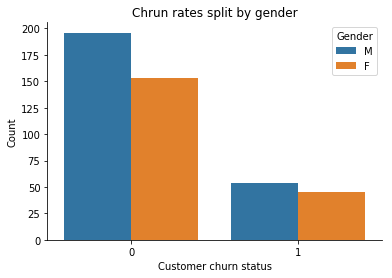

In [24]:
ax = sns.barplot(x='churn', y='count', hue='gender', data=gender_churn)
plt.xlabel('Customer churn status')
plt.ylabel('Count')
plt.legend(title='Gender', loc='best')
plt.title('Chrun rates split by gender')
sns.despine(ax=ax);

It looks like male customers represent a bigger population overall and hence there are more churned customers that are male. 

##### Number of songs played by gender

In [25]:
songs_gender_churn = df_spark.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId','gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avg_songs_played')\
    .toPandas()

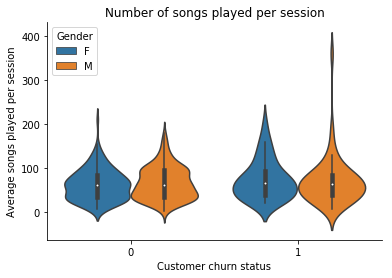

In [26]:
ax = sns.violinplot('churn', y='avg_songs_played', hue='gender', data=songs_gender_churn)
plt.xlabel('Customer churn status')
plt.ylabel('Average songs played per session')
plt.legend(title='Gender', loc='upper left')
plt.title('Number of songs played per session')
sns.despine(ax=ax);

Looks like churned customers played fewer songs on average but there is a bigger tail of outliers of male churned customers

In [27]:
gender_downgrade = df_spark.dropDuplicates(["userId", "gender"]).groupby(["downgrade", "gender"]).count().sort("downgrade").toPandas()

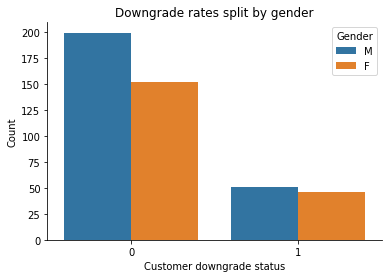

In [28]:
ax = sns.barplot(x='downgrade', y='count', hue='gender', data=gender_downgrade)
plt.xlabel('Customer downgrade status')
plt.ylabel('Count')
plt.legend(title='Gender', loc='best')
plt.title('Downgrade rates split by gender')
sns.despine(ax=ax);

The situation looks very similar in regards to donwgrade rates.

In [29]:
songs_gender_downgrade = df_spark.where('page == "NextSong"').groupby(['downgrade', 'userId', 'sessionId','gender']).count()\
    .groupby(['downgrade', 'userId', 'gender']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avg_songs_played')\
    .toPandas()

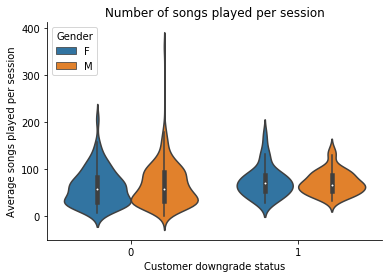

In [30]:
ax = sns.violinplot('downgrade', y='avg_songs_played', hue='gender', data=songs_gender_downgrade)
plt.xlabel('Customer downgrade status')
plt.ylabel('Average songs played per session')
plt.legend(title='Gender', loc='upper left')
plt.title('Number of songs played per session')
sns.despine(ax=ax);

We can see that downgraded customers played fewer songs as expected.

#### Level
Let's examine the split of churn and downgrade rates when the data is split by paid/free levels.

In [31]:
level_churn = df_spark.dropDuplicates(["userId", "level"]).groupby(["churn", "level"]).count().sort("churn").toPandas()

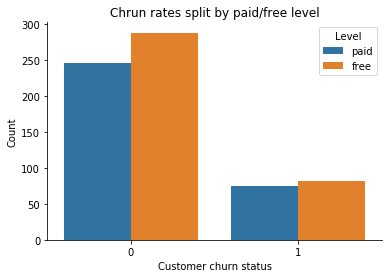

In [32]:
ax = sns.barplot(x='churn', y='count', hue='level', data=level_churn)
plt.xlabel('Customer churn status')
plt.ylabel('Count')
plt.legend(title='Level', loc='best')
plt.title('Chrun rates split by paid/free level')
sns.despine(ax=ax);

It looks like slightly more non-paying customers have churned, which I find surprising. 

In [33]:
level_downgrade = df_spark.dropDuplicates(["userId", "level"]).groupby(["downgrade", "level"]).count().sort("downgrade").toPandas()

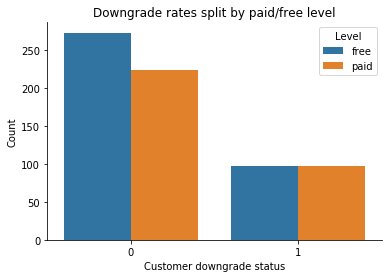

In [34]:
ax = sns.barplot(x='downgrade', y='count', hue='level', data=level_downgrade)
plt.xlabel('Customer downgrade status')
plt.ylabel('Count')
plt.legend(title='Level', loc='best')
plt.title('Downgrade rates split by paid/free level')
sns.despine(ax=ax);

It looks like there is no difference in downgrade between paying and non - paying customers. 

#### Page

In [35]:
# We know that only customers who are churning will have pages 'Cancel' and 'Cancellation Confirmation' so we remove them from this investigation
df_spark_filtered = df_spark.filter((df_spark.page != 'Cancel') &(df_spark.page != 'Cancellation Confirmation'))

In [36]:
page_churn = df_spark_filtered.dropDuplicates(["userId", "page"]).groupby(["churn", "page"]).count().sort("churn").toPandas()

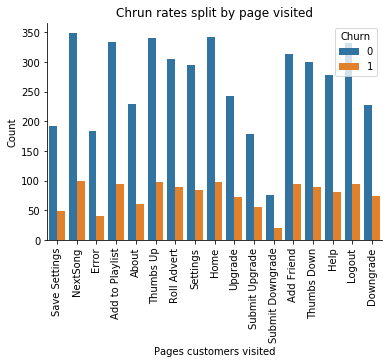

In [37]:
ax = sns.barplot(x='page', y='count', hue='churn', data=page_churn)
plt.xlabel('Pages customers visited')
plt.ylabel('Count')
plt.legend(title='Churn', loc='upper right')
plt.title('Chrun rates split by page visited')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine(ax=ax);

In [38]:
# We know that only customers who are churning will have page 'Submit Downgrade' so we remove it from this investigation
df_spark_filtered2 = df_spark.filter((df_spark.page != 'Submit Downgrade'))

In [39]:
page_downgrade = df_spark_filtered2.dropDuplicates(["userId", "page"]).groupby(["downgrade", "page"]).count().sort("downgrade").toPandas()

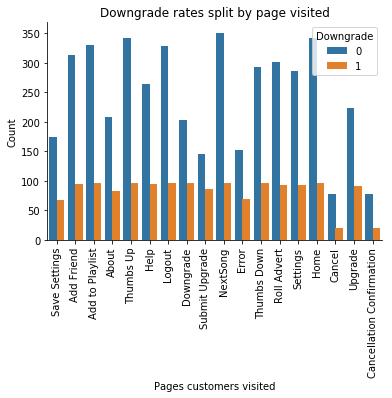

In [40]:
ax = sns.barplot(x='page', y='count', hue='downgrade', data=page_downgrade)
plt.xlabel('Pages customers visited')
plt.ylabel('Count')
plt.legend(title='Downgrade', loc='upper right')
plt.title('Downgrade rates split by page visited')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine(ax=ax);

We can see that downgraded customers have a bigger share of seeing the 'Error' page and perhaps 'Save Settings'

#### Hour of the Day

In [41]:
hour_churn = df_spark.dropDuplicates(["userId", "hour"]).groupby(["churn", "hour"]).count().sort("churn").toPandas()

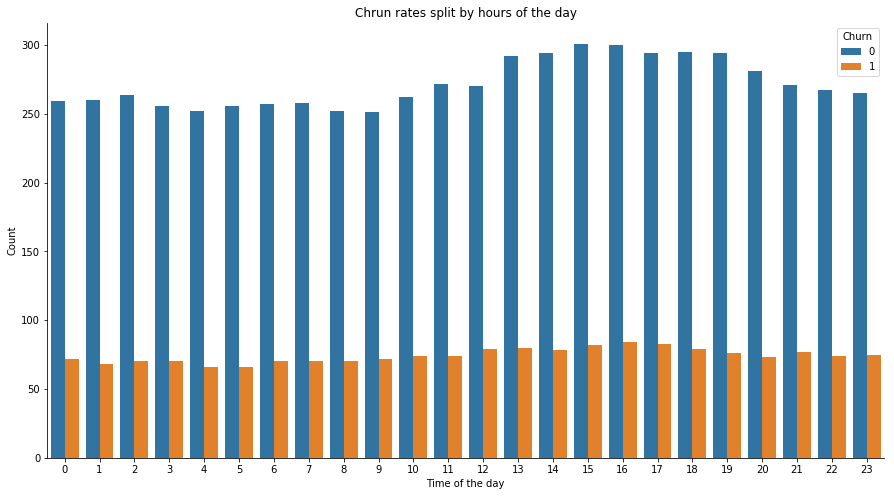

In [42]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x='hour', y='count', hue='churn', data=hour_churn)
plt.xlabel('Time of the day')
plt.ylabel('Count')
plt.legend(title='Churn', loc='best')
plt.title('Chrun rates split by hours of the day')
sns.despine(ax=ax);

We can see that the churning pattern follows the general usage pattern, going up arounf noon for about 7 hours.

In [43]:
hour_downgrade = df_spark.dropDuplicates(["userId", "hour"]).groupby(["downgrade", "hour"]).count().sort("downgrade").toPandas()

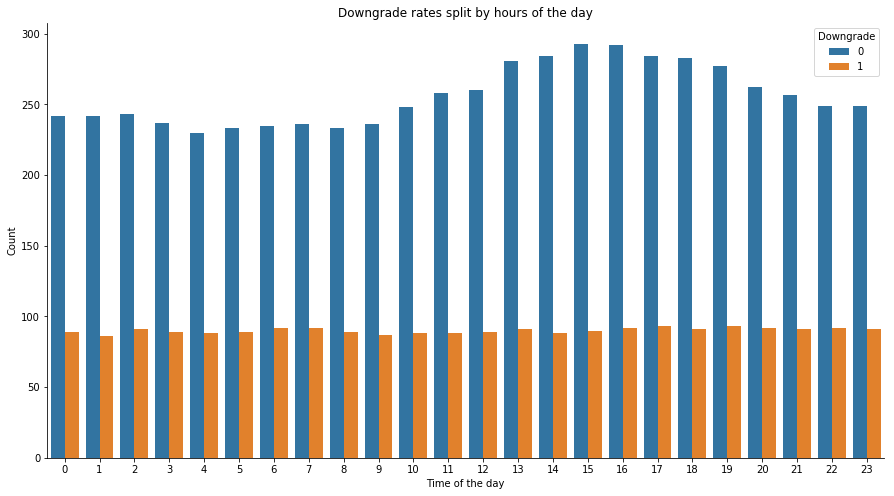

In [44]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x='hour', y='count', hue='downgrade', data=hour_downgrade)
plt.xlabel('Time of the day')
plt.ylabel('Count')
plt.legend(title='Downgrade', loc='best')
plt.title('Downgrade rates split by hours of the day')
sns.despine(ax=ax);

The above graph shows that there is no spike in account downgrade following the spike in general account usage, which is unexpected. 

#### Day of the Month

In [45]:
day_churn = df_spark.dropDuplicates(["userId", "day"]).groupby(["churn", "day"]).count().sort("churn").toPandas()

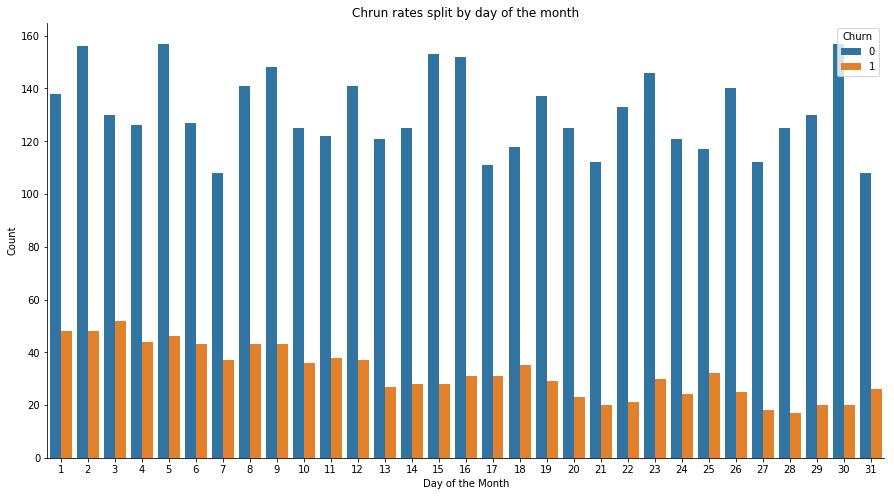

In [46]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x='day', y='count', hue='churn', data=day_churn)
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.legend(title='Churn', loc='best')
plt.title('Chrun rates split by day of the month')
sns.despine(ax=ax);

From the above graph we can see that churn rates are higher in the beginning of the month perhaps due to the timings of salary being paid or bills being due.

In [47]:
day_downgrade = df_spark.dropDuplicates(["userId", "day"]).groupby(["downgrade", "day"]).count().sort("downgrade").toPandas()

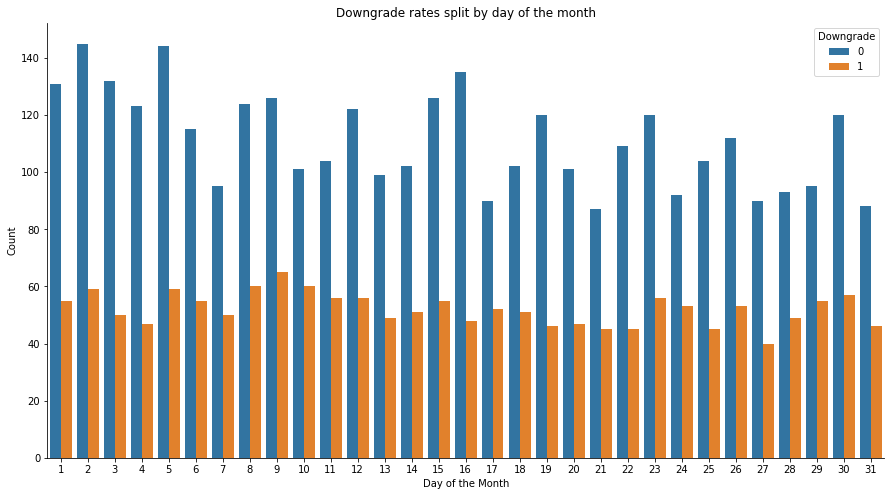

In [48]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x='day', y='count', hue='downgrade', data=day_downgrade)
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.legend(title='Downgrade', loc='best')
plt.title('Downgrade rates split by day of the month')
sns.despine(ax=ax);

From the above graph we can see that downgrade does not follow a similar trend, but rather has a few spikes around the 1st and 2nd, 8th, 9th, 10th and towards teh end of the month.

#### Month

In [49]:
df_spark.select("month").distinct().show()

+-----+
|month|
+-----+
|   12|
|   10|
|   11|
+-----+



Unfortunately, we only have data for October, November and December. Hence, I will not examine with this split because no yearly trend will be observed. 

## Feature Engineering

Now that I am familiar wih the dataset and its features, I will choose the features that I find promising to later train my model on.

##### 1. Gender
I want to include a demographic feature and I dont think location is particularly applicable in this sutuation so I will include gender. Please note, that I have replaced M and F with 0 and 1 labels respectively.

In [50]:
f1 = df_spark \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int'))

In [51]:
f1.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               448|                448|
|   mean| 67520.34821428571| 0.4419642857142857|
| stddev|105964.58428485187|0.49717562790790404|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



##### 2. Paid vs Free
I want to examine whether being a paying customer affects churning rates

In [52]:
f2 = df_spark \
    .select("userId", "level") \
    .dropDuplicates() \
    .replace(['free', 'paid'], ['0', '1'], 'level') \
    .select('userId', col('level').cast('int'))

In [53]:
f2.describe().show()

+-------+-----------------+------------------+
|summary|           userId|             level|
+-------+-----------------+------------------+
|  count|              691|               691|
|   mean|67259.47033285093|0.4645441389290883|
| stddev|106161.0250663008|0.4991025734716591|
|    min|               10|                 0|
|    max|               99|                 1|
+-------+-----------------+------------------+



##### 3. Number of sessions
Now, I want to explore the different features that represent customer's engagement with the site, starting with how many sessions they had i.e. logged in.

In [54]:
f3 = df_spark \
    .select('userID','sessionId') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'total_sessions')

In [55]:
f3.describe().show()

+-------+------------------+------------------+
|summary|            userID|    total_sessions|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571|1178.5825892857142|
| stddev|105964.58428485185| 1380.627964752405|
|    min|                10|                 3|
|    max|                99|              9767|
+-------+------------------+------------------+



##### 4. Number of thumbs up
Number of songs that customer has liked and 'thumbed up' represents engagement with the site

In [56]:
f4 = df_spark \
    .select('userID','page') \
    .where(df_spark.page == 'Thumbs Up') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_up')

In [57]:
f4.describe().show()

+-------+------------------+-----------------+
|summary|            userID|     num_thumb_up|
+-------+------------------+-----------------+
|  count|               439|              439|
|   mean| 67308.81548974942|54.27334851936219|
| stddev|106228.80408254784|69.94135178778984|
|    min|                10|                1|
|    max|                99|              506|
+-------+------------------+-----------------+



##### 5. Number of thumbs down
Similarly as the feature above, the number of thumbs down represents customer not enjoying songs

In [58]:
f5 = df_spark \
    .select('userID','page') \
    .where(df_spark.page == 'Thumbs Down') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_down')

In [59]:
f5.describe().show()

+-------+------------------+------------------+
|summary|            userID|    num_thumb_down|
+-------+------------------+------------------+
|  count|               389|               389|
|   mean| 70031.19537275065|12.624678663239074|
| stddev|106895.73735311363|13.582432851937991|
|    min|                10|                 1|
|    max|                99|                80|
+-------+------------------+------------------+



##### 6. Number of friends added
Similarly to above, the number of friends added should correspond to the engagement and enjoyment of the product.

In [60]:
f6 = df_spark \
    .select('userID','page') \
    .where(df_spark.page == 'Add Friend') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'add_friend')

In [61]:
f6.describe().show()

+-------+------------------+------------------+
|summary|            userID|        add_friend|
+-------+------------------+------------------+
|  count|               409|               409|
|   mean|  66368.3716381418|19.772616136919314|
| stddev|106064.01609030593|22.494435766272826|
|    min|                10|                 1|
|    max|                99|               158|
+-------+------------------+------------------+



##### 7. Number of 'next song' clicks
The number of times the customer clicks 'Next Song' could be indicative that they are enjoying their experience.

In [62]:
f7 = df_spark.where('page == "NextSong"') \
    .groupby(['userId', 'sessionId']) \
    .count() \
    .groupby(['userId']) \
    .agg({'count':'avg'}) \
    .withColumnRenamed('avg(count)', 'avg_songs_played')

In [63]:
f7.describe().show()

+-------+------------------+------------------+
|summary|            userId|  avg_songs_played|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571| 65.61168409976811|
| stddev|105964.58428485185|39.494965666172675|
|    min|                10|               1.0|
|    max|                99|             360.0|
+-------+------------------+------------------+



##### 8. Number of songs added to a playlist
Similarly to the above, the more songs a customer adds to a playlist, the more likely they are enjoying their experience with the product.

In [64]:
f8 = df_spark \
    .select('userID','page') \
    .where(df_spark.page == 'Add to Playlist') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'add_to_playlist')

In [65]:
f8.describe().show()

+-------+------------------+------------------+
|summary|            userID|   add_to_playlist|
+-------+------------------+------------------+
|  count|               428|               428|
|   mean| 65764.93457943926|28.852803738317757|
| stddev|105363.38578382804|  33.9130906945663|
|    min|                10|                 1|
|    max|                99|               248|
+-------+------------------+------------------+



##### 9. Number of artist
Similarly to above, the more artists the user has listned to, teh more likely they are to be enageged with the product.

In [66]:
f9 = df_spark \
    .filter(df_spark.page=="NextSong") \
    .select("userId", "artist") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "artist_count")

In [67]:
f9.describe().show()

+-------+------------------+-----------------+
|summary|            userId|     artist_count|
+-------+------------------+-----------------+
|  count|               448|              448|
|   mean| 67520.34821428571|658.9799107142857|
| stddev|105964.58428485184|625.8826980519569|
|    min|                10|                1|
|    max|                99|             3507|
+-------+------------------+-----------------+



##### Churn label

In [68]:
label = df_spark \
    .select('userId', col('churn').alias('label')) \
    .dropDuplicates()

In [69]:
label.describe().show()

+-------+------------------+-------------------+
|summary|            userId|              label|
+-------+------------------+-------------------+
|  count|               448|                448|
|   mean| 67520.34821428571|0.22098214285714285|
| stddev|105964.58428485188| 0.4153723104396363|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



Joining all of the features together

In [70]:
data = f1.join(f2,'userID','outer') \
    .join(f3,'userID','outer') \
    .join(f4,'userID','outer') \
    .join(f5,'userID','outer') \
    .join(f6,'userID','outer') \
    .join(f7,'userID','outer') \
    .join(f8,'userID','outer') \
    .join(f9,'userID','outer') \
    .join(label,'userID','outer') \
    .drop('userID') \
    .fillna(0)

data.show(5)

+------+-----+--------------+------------+--------------+----------+----------------+---------------+------------+-----+
|gender|level|total_sessions|num_thumb_up|num_thumb_down|add_friend|avg_songs_played|add_to_playlist|artist_count|label|
+------+-----+--------------+------------+--------------+----------+----------------+---------------+------------+-----+
|     1|    0|           137|           4|             3|         3|            48.0|              1|          94|    1|
|     0|    0|           395|          15|             5|         2|            62.0|              6|         287|    1|
|     0|    1|           395|          15|             5|         2|            62.0|              6|         287|    1|
|     1|    1|           152|           8|             0|         2|            22.4|              3|         108|    1|
|     1|    0|           152|           8|             0|         2|            22.4|              3|         108|    1|
+------+-----+--------------+---

## Modelling

I will be splitting the dataset into train, test and validation subsets. Then I will be trying out 3 models and evaluation their performance using F-1 score on the validation dataset. However, first I will make sure that the features chosen above are in the right format and are ready to be used in model training.

### 1. Vectorise the features

In [71]:
col = ['gender',\
        'level',\
        'total_sessions',\
        'num_thumb_up',\
        'num_thumb_down',\
        'add_friend',\
        'avg_songs_played',\
        'add_to_playlist',\
        'artist_count']
assembler = VectorAssembler(inputCols=col, outputCol="NumFeatures")
data = assembler.transform(data)

### 2. Normalise the features

We also need to normalize the features (subtract mean and divide by standard deviation) so that features with naturally bigger values will not dominate over other features

In [72]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

### 3. Split the dataset

I will be splitting the data into Train: Test: Validate subsets with 60:20:20 respectively by performming random split twice. 

In [73]:
train, rest = data.randomSplit([0.6, 0.4], seed=27)
validation, test = rest.randomSplit([0.5, 0.5], seed=27)

### 4. Compute the Baseline F-1 score

In [74]:
data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  157|
|    0|  534|
+-----+-----+



As we can see from above, the label column is unbalanced (many more 0 values than 1), we will consider predicting 0 values for all users as the baseline model.

In [75]:
baseline = test.withColumn('prediction', lit(0.0))

In [76]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Baseline model performance:')
print('F-1 Score:{}'.format(evaluator.evaluate(baseline, {evaluator.metricName: "f1"})))

Baseline model performance:
F-1 Score:0.6566804608420276


As can be seen from above, the baseline F-1 score is 65% so when picking the best model later on we will keep this figure in mind.

### 5. Build and train models

#### 5.1 Logistic Regression

In [77]:
# Initialising the classifier
lr = LogisticRegression(maxIter=10)

In [78]:
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

In [79]:
# Building a paramGrid
paramGrid = ParamGridBuilder() \
    .build()

lr_cv = CrossValidator(estimator=lr,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [80]:
# Fitting the model
lr_cv_model = lr_cv.fit(train)

In [81]:
lr_results = lr_cv_model.transform(validation)

In [82]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Logistic Regression performance:')
print('F-1 Score:{}'.format(evaluator.evaluate(lr_results, {evaluator.metricName: "f1"})))

Logistic Regression performance:
F-1 Score:0.8013191894464845


We can see that F-1 score improved from the baseline 65% to 80% using Logistic Regression which is acceptable. 

#### 5.2 Decision Tree Classifier

In [83]:
# Initialising the classifier
dts = DecisionTreeClassifier()

In [84]:
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

In [85]:
# Building a paramGrid
paramGrid = ParamGridBuilder() \
    .build()

dts_cv = CrossValidator(estimator=dts,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [86]:
# Fitting the model
dts_cv_model = dts_cv.fit(train)

In [87]:
dts_results = dts_cv_model.transform(validation)

In [88]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Decision Tree Classifier performance:')
print('F-1 Score:{}'.format(evaluator.evaluate(dts_results, {evaluator.metricName: "f1"})))

Decision Tree Classifier performance:
F-1 Score:0.8233492822966506


Decision Tree classifier is a more sophisticated model than logistic regression, we as expected the F-1 score is higher but not by much (approx. 2%)

#### 5.3 Gradient Boosted Trees

In [89]:
# Initialising the classifier
gbt = GBTClassifier(maxIter=10,seed=27)
# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

In [90]:
# Building a paramGrid
paramGrid = ParamGridBuilder() \
    .build()

gbt_cv = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [91]:
# Fitting the model
gbt_cv_model = gbt_cv.fit(train)

In [92]:
gbt_results = gbt_cv_model.transform(validation)

In [93]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Gradient Boosted Trees performance:')
print('F-1 Score:{}'.format(evaluator.evaluate(gbt_results, {evaluator.metricName: "f1"})))

Gradient Boosted Trees performance:
F-1 Score:0.8662211083263716


In [106]:
gbt_cv_model.save('gbt_cv_model.model')

We can see that Gradient Boosted Tree (which builds on weak learners) develops decision tree model further, so as expected it has performed better than all the previousl models.

As can be seen from above, the Gradient Boosted Tree model has outperformed the other models when looking at the F-1 score. It can done 22% better than the baseline model of predicting a 0 churn lable for everyone.

When choosing the best model we could also have looked at the run time. Considering that the full dataset is substantial (12GB) the resources required to fit the model would most probably be an important aspect to the model use. However, in our case using the medium sized dataset (242 MB), run-time was not a big concern so the best model is chosen primarily on the F-1 score. Hence, we recommend using Gradient Boosted Tree model for this problem.

### 6. Hyperparameter tuning

Now that we have one model that we consider the most appropriate in this circumstance, we will be fine tuning its parameters.

In [94]:
GBTClassifier(maxIter=10,seed=27)

# Building a paramGrid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[3, 5, 10]) \
    .addGrid(gbt.maxIter, [10,15]) \
    .addGrid(gbt.maxBins ,[10, 5]) \
    .build()

# Set an evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

gbt_cv2 = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [ ]:
gbt_cv_model2 = gbt_cv2.fit(train)

In [96]:
gbt_cv_model2.avgMetrics

[0.6877914441367314,
 0.708401070998344,
 0.6831252543339409,
 0.7110629174626609,
 0.7090755824307415,
 0.7108033853938818,
 0.7144877487297507,
 0.7073383869712211,
 0.7224098569750189,
 0.6978468820060982,
 0.7258516603342268,
 0.6995891059195012]

In [103]:
gbt_cv_model2.save('gbt_cv_model2.model')

#### 6.1 Optimal Model

In [112]:
final_model = gbt_cv_model2.bestModel

#### 6.2 Feature Importance

Let's plot the values of the feature coefficients

In [114]:
var_imp = final_model.featureImportances.values

In [116]:
col = ['gender',\
        'level',\
        'total_sessions',\
        'num_thumb_up',\
        'num_thumb_down',\
        'add_friend',\
        'avg_songs_played',\
        'add_to_playlist',\
        'artist_count']
y_pos = np.arange(len(col))

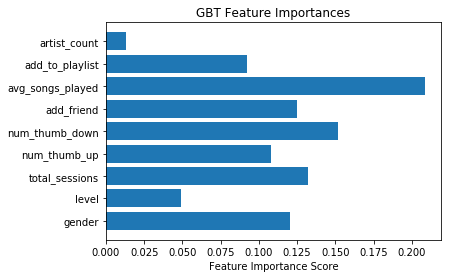

In [117]:
plt.barh(y_pos, var_imp, align='center')
plt.yticks(y_pos, col)
plt.xlabel('Feature Importance Score')
plt.title('GBT Feature Importances');

The three most important features identified were
- Average songs played
- Number of thumbs down given
- Total sessions

which were expected because they highlight users' enagagement with the service. 

The three least important features were:
- Number of artists listened to
- Free vs Paid level of membership
- Number of songs added to playlists

I was slighty surprised by these as I thought these features will also correlate with engagement.

## Conclusion

To summarise the steps taken in this project:
1. Medium dataset (242 MB) was imported using Spark
2. The data was cleaned, rows with an empty UserID (approx. 16000) were removed seeing as userID was afterwards treated as a unique identifier
3. Churn label was defined
4. Dataset was explored in a visual way to understand which features looked promising in churn prediction
5. The most promising features were defined and joined together into a clean dataset
6. Before building teh models, the features were vectorised and normalised
7. Data was split into train, test and validation subsets
8. Baseline F-1 score was computed
9. Logistic Regression, Decisions Trees and Gradient Boosted Trees models were trained and their F-1 score performance compared
10. GBT was chosen as the best model to use in this scenario
11. GBT model's hyperparameters were fine tuned to give us the final model 
12. Feature importance was investigated

### Potential Imporovements

- Due to the resource restrictions, I have used the meduim subset of the original dataset. The models would have 50 times more data to learn on if the full dataset was used, which usually results in better predictive models.
- It would probably be useful to look at other features to include in the model such as time since registration,time spent interacting wiht the service, location etc
- It could be useful to compare performance of other models such as Random Forest and SVM

### Reflection

This has been a expansive project that allowed me to use the skills I have learned over the course of the nanodegree. The original dataset comprises of millions of rows detailing users' interactions with a music playing service. The columns included things like somgs' names and artists listnened, thumbs up or down given, friends added all timestamped. Data's size gave me an opportunity to learn about managing 'big data' by using Spark in this case. 

I had a really hard time reading the data into the IBM Watson Studio Notebook, even though I have followed Udacity's guidelines, I ended up with a wrongly configured notebook which prevented me from using Spark. The errors I was seeing in the notebook were not descriptive enough for me or Udacity's mentors to understand what was wrong. It tooks me over a week to carry out something that should have taken under a minute. As frustrating as that was, I learned a great deal about spark configuration and json file formats because of the amount of research I had to do. 

As mentioned previously, I used IBM Watson Studio notebook for this project, because it allowed me to get an understanding of the workings of Spark wihtout having to pay for a cloud service within AWS. I am happy I have decided to do this project and the learning associated with it because it taugh me some 'fundamentals' about computers that people from non- computer science background often do not naturally learn. This included CPU, memory storage, network connections etc. 

Furthermore, an educational experience in this project was learning how to interact with the Spark dataframe. Initially, being used to pandas dataframes I found the notation slightly confusing but by the end of it I feel comfortable carrying out basic tasks and looking up and implementing more complex solutions.